# Navigation

---

### 1. Start the Environment

We will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [4]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

# please do not modify the line below
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain_name)

BananaBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will see how to use the Python API to control the agent and receive feedback from the environment.

Note that you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 4. Model Training

Let's train the agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- The following training cells import `AgentPriority` class, which implements priority Double DQN, from `dqn_priority_agent` module located in the same directory as this notebook.
- After training the agent, by setting `train_mode=False`, you can watch the agent with the trained model (see Section 5). 

First, let's set some hyperparameters.  By changing those settings, you can do a parameter search.

In [6]:
HIDDEN_LAYERS = [64, 32, 16, 8]
LR = 2.5e-4
N_EPISODES = 3000
EPS_START = 1.0
MIN_EPS = 0.0001
EPS_DECAY = 0.9
MIN_SAVE_SCORE = 16.0  # minimum average score to save the model

Then import the agant.

In [7]:
from dqn_priority_agent import AgentPriority

priority_agent = AgentPriority(state_size=state_size,
                               action_size=action_size,
                               seed=0,
                               hidden_layers=HIDDEN_LAYERS,
                               lr=LR,
                               alpha=0.5,
                               beta=0.4)

The next cell is the main script to train the agent.

In [8]:
def dqn(agent, n_episodes=1000, eps_start=1.0, min_eps=0.01, eps_decay=0.99):
    print("Agent: {}".format(type(agent).__name__))
    print("hidden_layers {}, lr {}".format(HIDDEN_LAYERS, LR))
    print("n_eposode {}, eps_start {}, min_eps {}, eps_decay {}, gamma {}".format(n_episodes,
                                                                                  eps_start,
                                                                                  min_eps,
                                                                                  eps_decay,
                                                                                  agent.get_gamma()))
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    ave_scores = []
    eps = eps_start
    
    max_ave_score = MIN_SAVE_SCORE
    lr = LR
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]  # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        
        # If priority sampling agent is in use, once episode reaches 2000,
        # change the agent to the uniform sampling
        if type(agent).__name__ == "AgentPriority" and i_episode % 2000 == 0:
            agent.set_uniform_sampling()
            
        # every 1000 episode, reduce lr by half
        if i_episode % 1000 == 0:
            lr /= 2
            agent.set_lr(lr)
            print("\rLR updated {}".format(lr))
        
        while True:
            action = agent.act(state, eps)                 # get action from agent
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                break
        
        eps = max(min_eps, eps_decay*eps) # decrease epsilon
        scores.append(score)
        scores_window.append(score)
        
        mean_ave_score = np.mean(scores_window)
        ave_scores.append(mean_ave_score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_ave_score), end="")
        if mean_ave_score > max_ave_score:
            agent.save_model()
            max_ave_score = mean_ave_score
            
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_ave_score))

    return scores, ave_scores, max_ave_score


Train the agent and plot the result.  

**Note:** If you just want to see how the already trained model stored in `priority_ddqn_model.pth` works, skip the next cell and go to the next section.

Agent: AgentPriority
hidden_layers [64, 32, 16, 8], lr 0.00025
n_eposode 3000, eps_start 1.0, min_eps 0.0001, eps_decay 0.9, gamma 0.99
Episode 100	Average Score: 6.29
Episode 200	Average Score: 8.11
Episode 300	Average Score: 12.10
Episode 400	Average Score: 12.44
Episode 500	Average Score: 14.70
Episode 600	Average Score: 14.12
Episode 700	Average Score: 15.88
Episode 800	Average Score: 14.76
Episode 900	Average Score: 15.36
LR updated 0.000125 Score: 15.28
Episode 1000	Average Score: 15.24
Episode 1100	Average Score: 14.69
Episode 1200	Average Score: 15.83
Episode 1300	Average Score: 15.24
Episode 1400	Average Score: 14.59
Episode 1500	Average Score: 15.95
Episode 1600	Average Score: 14.76
Episode 1700	Average Score: 16.32
Episode 1800	Average Score: 14.90
Episode 1900	Average Score: 17.01
LR updated 6.25e-05e Score: 15.96
Episode 2000	Average Score: 15.93
Episode 2100	Average Score: 15.98
Episode 2200	Average Score: 16.63
Episode 2300	Average Score: 15.49
Episode 2400	Average Score

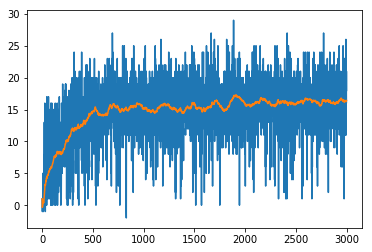

In [9]:
scores, ave_scores, max_ave_score = dqn(priority_agent, N_EPISODES, EPS_START, MIN_EPS, EPS_DECAY)

print("MAX AVE SCORE {}".format(max_ave_score))
plt.plot(scores)
plt.plot(ave_scores)
plt.show()

### 5. Let's see how the trained model works
The next cell loads the model trained in the previous section and use that to play Banana.  An Unity window will open, and you can see how your agent plays Banana.

In [8]:
ave_score = 0.0
priority_agent.load_model("priority_ddqn_model.pth")
num_plays=100

for e in range(num_plays):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment with 
    state = env_info.vector_observations[0]            # train_mode=False 
    score = 0                                          

    while True:
        action = priority_agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        if done:
            break    
    
    print(score, end=", ")
    if (e+1) % 10 == 0:
        print("\n")
    ave_score += score
    
print("Average score: {}".format(ave_score/num_plays))

20.0, 21.0, 12.0, 18.0, 19.0, 16.0, 20.0, 19.0, 9.0, 17.0, 

12.0, 13.0, 6.0, 17.0, 19.0, 16.0, 24.0, 20.0, 18.0, 11.0, 

13.0, 17.0, 13.0, 17.0, 19.0, 18.0, 18.0, 14.0, 19.0, 21.0, 

21.0, 27.0, 21.0, 24.0, 18.0, 20.0, 18.0, 17.0, 19.0, 19.0, 

14.0, 19.0, 15.0, 19.0, 12.0, 20.0, 22.0, 17.0, 25.0, 19.0, 

21.0, 17.0, 20.0, 19.0, 10.0, 15.0, 19.0, 21.0, 16.0, 18.0, 

13.0, 19.0, 17.0, 24.0, 13.0, 17.0, 26.0, 15.0, 10.0, 22.0, 

19.0, 19.0, 21.0, 14.0, 22.0, 9.0, 6.0, 19.0, 13.0, 20.0, 

12.0, 12.0, 13.0, 17.0, 18.0, 15.0, 22.0, 15.0, 17.0, 18.0, 

17.0, 20.0, 19.0, 11.0, 18.0, 15.0, 15.0, 16.0, 13.0, 15.0, 

Average score: 17.14


### 6. Comparison with Uniform Sampling
Out of curiosity, let's see how the agent trained with vanilla DQN works.  For the fair comparison, the hyperparameters have to be same as those used in Section 4.  The vanilla DQN agent is implemented in `dqn_agent` which is located in the same directory as this notebook.

In [9]:
HIDDEN_LAYERS = [64, 32, 16, 8]
LR = 2.5e-4
N_EPISODES = 3000
EPS_START = 1.0
MIN_EPS = 0.0001
EPS_DECAY = 0.9
MIN_SAVE_SCORE = 16.0

In [9]:
from dqn_agent import AgentUniform

simple_agent = AgentUniform(state_size=state_size, action_size=action_size, seed=0, hidden_layers=HIDDEN_LAYERS, lr=LR)

Agent: AgentUniform
hidden_layers [64, 32, 16, 8], lr 0.00025
n_eposode 3000, eps_start 1.0, min_eps 0.0001, eps_decay 0.9, gamma 0.99
Episode 100	Average Score: 3.55
Episode 200	Average Score: 10.94
Episode 300	Average Score: 13.71
Episode 400	Average Score: 14.71
Episode 500	Average Score: 15.45
Episode 600	Average Score: 15.90
Episode 700	Average Score: 15.55
Episode 800	Average Score: 17.23
Episode 900	Average Score: 16.16
LR updated 0.000125 Score: 16.62
Episode 1000	Average Score: 16.63
Episode 1100	Average Score: 16.05
Episode 1200	Average Score: 16.13
Episode 1300	Average Score: 16.99
Episode 1400	Average Score: 16.17
Episode 1500	Average Score: 15.58
Episode 1600	Average Score: 16.63
Episode 1700	Average Score: 16.41
Episode 1800	Average Score: 15.39
Episode 1900	Average Score: 15.66
LR updated 6.25e-05e Score: 16.21
Episode 2000	Average Score: 16.09
Episode 2100	Average Score: 16.15
Episode 2200	Average Score: 16.39
Episode 2300	Average Score: 15.47
Episode 2400	Average Score

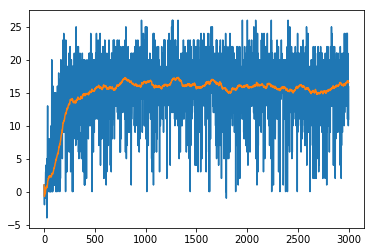

In [10]:
scores, ave_scores, max_ave_score = dqn(simple_agent, N_EPISODES, EPS_START, MIN_EPS, EPS_DECAY)

plt.plot(scores)
plt.plot(ave_scores)
plt.show()

Let's run the trained model with vanila DQN.

In [12]:
ave_score = 0.0
simple_agent.load_model("vanilla_dpq.pth")
num_plays=100

for e in range(num_plays):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment with 
    state = env_info.vector_observations[0]            # train_mode=False 
    score = 0                                          

    while True:
        action = simple_agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        if done:
            break    

    print(score, end=", ")
    if (e+1) % 10 == 0:
        print("\n")
    ave_score += score

print("Average score: {}".format(ave_score/num_plays))

12.0, 22.0, 14.0, 15.0, 9.0, 16.0, 19.0, 12.0, 11.0, 13.0, 

22.0, 18.0, 17.0, 14.0, 16.0, 16.0, 16.0, 17.0, 12.0, 14.0, 

20.0, 10.0, 17.0, 17.0, 16.0, 14.0, 18.0, 19.0, 19.0, 18.0, 

19.0, 15.0, 14.0, 18.0, 6.0, 9.0, 19.0, 21.0, 14.0, 13.0, 

18.0, 15.0, 16.0, 18.0, 17.0, 17.0, 17.0, 20.0, 20.0, 9.0, 

19.0, 20.0, 15.0, 19.0, 18.0, 12.0, 14.0, 14.0, 22.0, 17.0, 

18.0, 14.0, 15.0, 15.0, 22.0, 15.0, 15.0, 21.0, 17.0, 16.0, 

13.0, 21.0, 19.0, 17.0, 11.0, 19.0, 12.0, 22.0, 14.0, 15.0, 

14.0, 12.0, 12.0, 16.0, 19.0, 16.0, 15.0, 11.0, 19.0, 17.0, 

14.0, 17.0, 18.0, 16.0, 25.0, 22.0, 18.0, 10.0, 16.0, 19.0, 

Average score: 16.15


In [ ]:
env.close()